In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
47325,NaN,NaN,International,2020-09-29,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47326,NaN,NaN,International,2020-09-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47327,NaN,NaN,International,2020-10-01,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


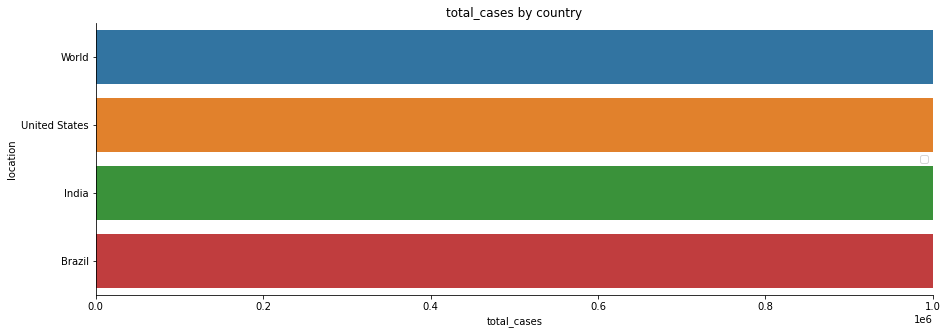

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


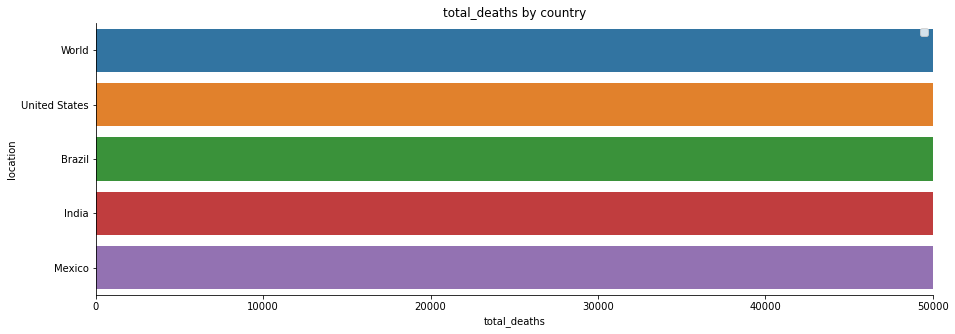

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


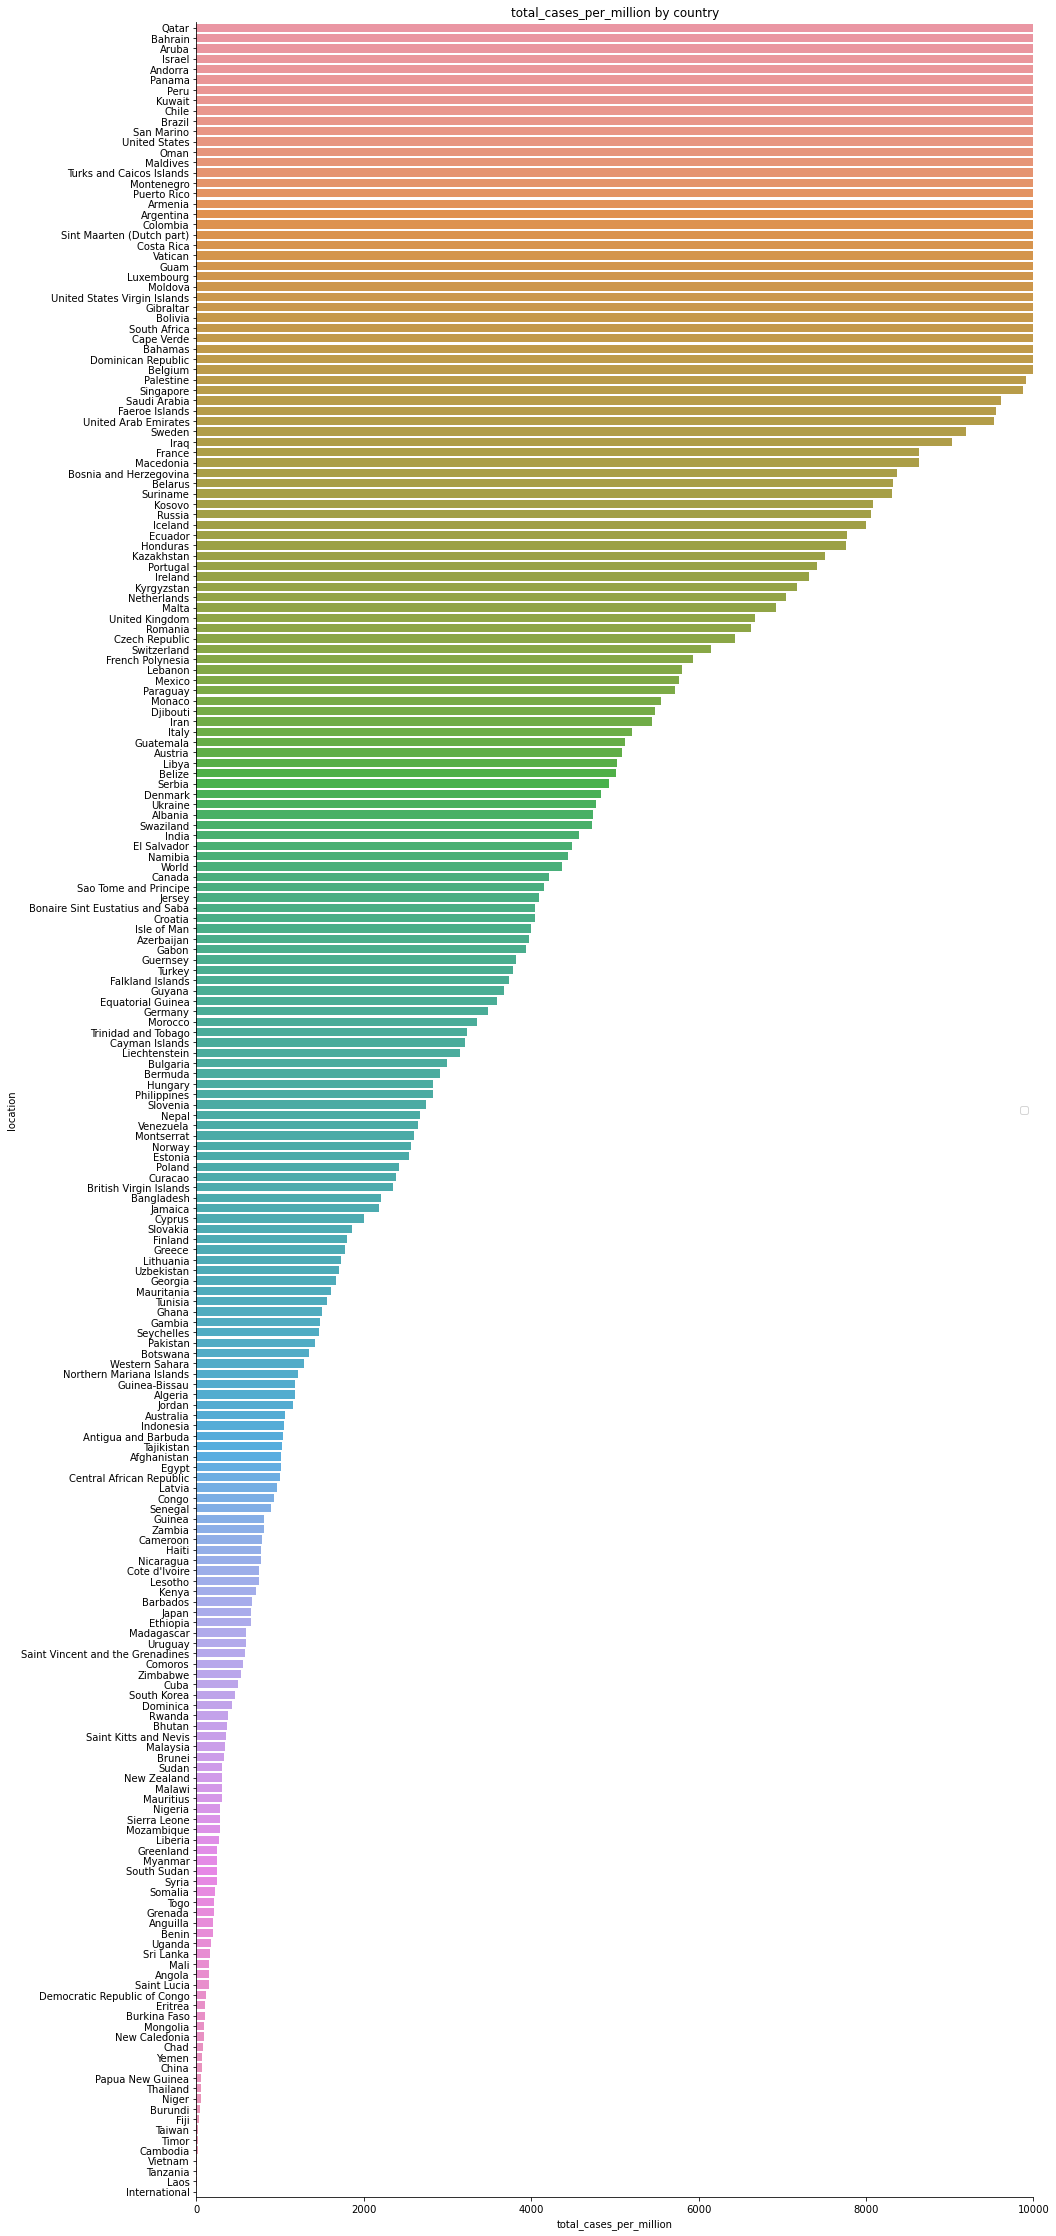

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


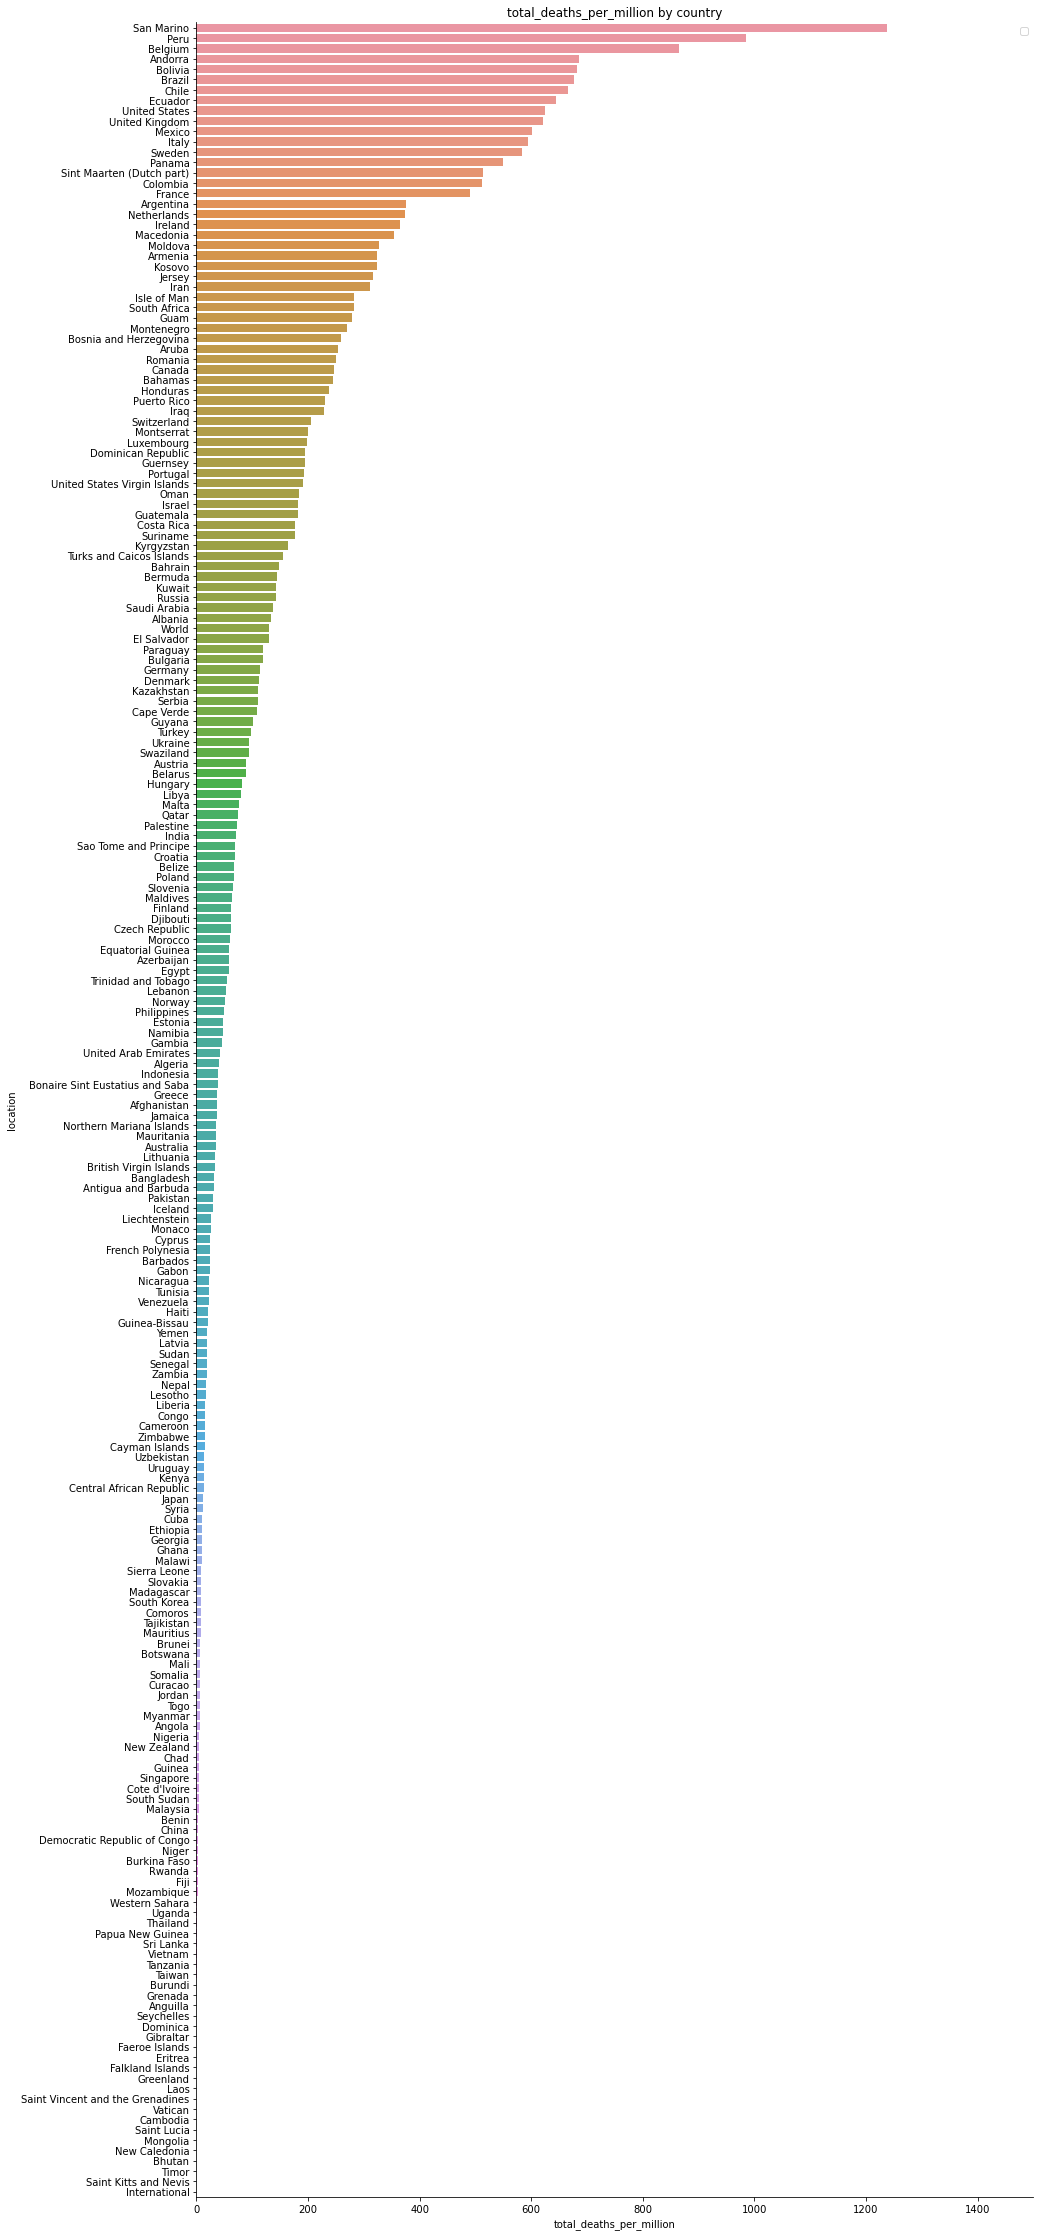

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

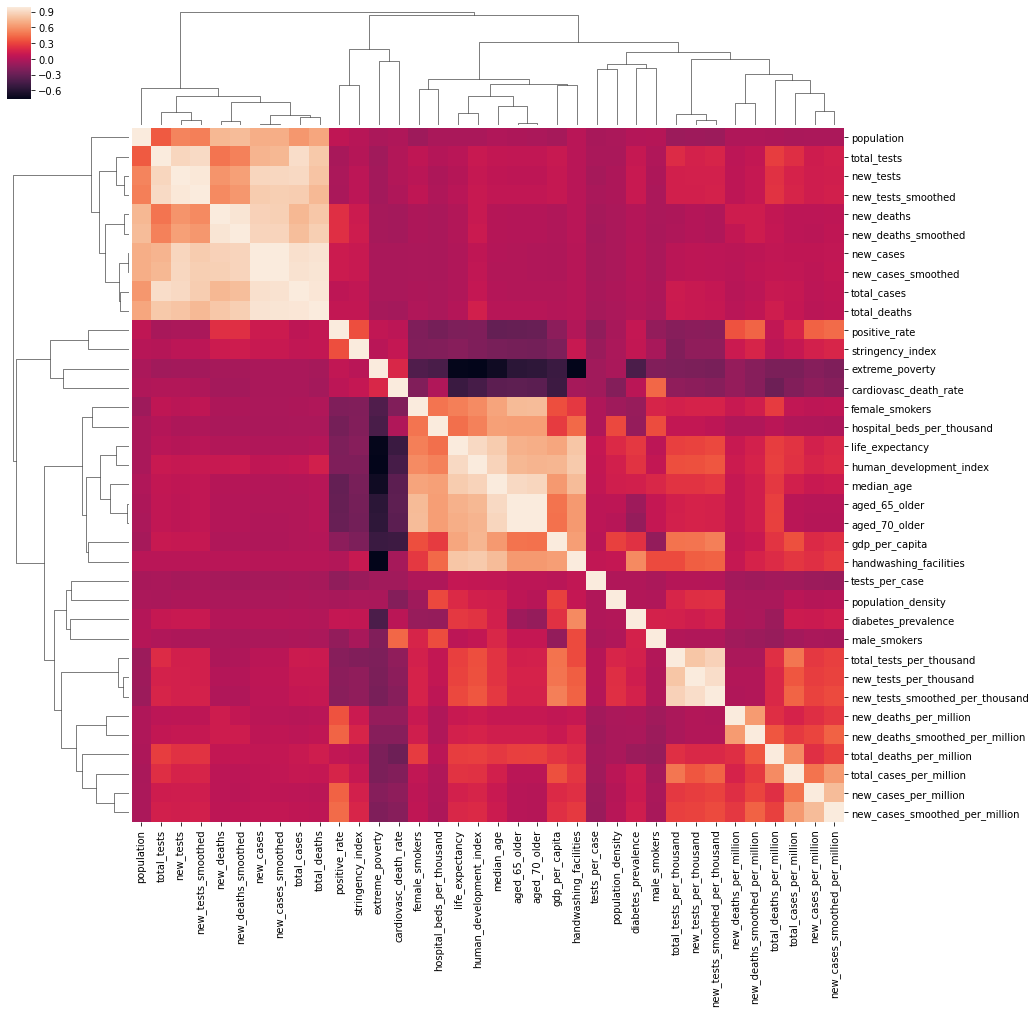

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9981868796294185 (+/- 0.0024302604086328004)
Coef :  [1.02974079e+00 7.82198722e-05 8.04590560e-05]
3 Last_days :  [[33436665 33725618 34029923]]
Today :  34029923
Prediction + :  518848
Tomorow :  34548771
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995784768928346 (+/- 0.0002410646486187392)
Coef :  [0.27173949 0.35914091 0.37889251]
3 Last_days :  [[1002903 1009109 1015043]]
Today :  1015043
Prediction + :  8078
Tomorow :  1023121
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.6826496306422087 (+/- 2.3758357261559175)
Coef :  [-0.67434736  0.72857282  0.95317037]
3 Last_days :  [[542639 550690 563535]]
Today :  563535
Prediction + :  8739
Tomorow :  572274
                                     
--------- Total Death -----------------
                                     
R^2: 0.7573454492773865 (+/- 0.33681466747225647)
Coef :  [-0.74319606  0.78687017  0.95529252]
3 Last_days :  [[31808 31893 31956]]
Today :  31956
Prediction + :  81
Tomorow :  32037
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9715242573554604 (+/- 0.03202505436174537)
Coef :  [-0.33181384 -0.00698082  1.3330584 ]
3 Last_days :  [[90505 90528 90528]]
Today :  90528
Prediction + :  15
Tomorow :  90543
                                     
--------- Total Death -----------------
                                     
R^2: -13.257987395910533 (+/- 20.0609677789187)
Coef :  [-0.07785469  0.0124996   1.05699297]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  5
Tomorow :  4744
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9602461480593617 (+/- 0.05503045130293716)
Coef :  [-0.8038261   0.88889293  0.91447403]
3 Last_days :  [[311364 313011 314861]]
Today :  314861
Prediction + :  1430
Tomorow :  316291
                                     
--------- Total Death -----------------
                                     
R^2: -0.16368385737243787 (+/- 1.6292395232772454)
Coef :  [-0.81639247  0.89368907  0.92166722]
3 Last_days :  [[35851 35875 35894]]
Today :  35894
Prediction + :  38
Tomorow :  35932
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.4035670555773565 (+/- 1.9750032457229265)
Coef :  [-0.19845443  0.13857337  1.07000394]
3 Last_days :  [[748266 758172 769188]]
Today :  769188
Prediction + :  10388
Tomorow :  779576
                                     
--------- Total Death -----------------
                                     
R^2: -0.7027911926991036 (+/- 2.123663109214377)
Coef :  [-0.73077645  0.6474386   1.08245064]
3 Last_days :  [[31411 31614 31791]]
Today :  31791
Prediction + :  173
Tomorow :  31964
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9179680408853391 (+/- 0.1121065164269476)
Coef :  [0.18699877 0.40978078 0.41541956]
3 Last_days :  [[7148044 7191061 7233043]]
Today :  7233043
Prediction + :  75427
Tomorow :  7308470
                                     
--------- Total Death -----------------
                                     
R^2: 0.9854359558425448 (+/- 0.019292630907849648)
Coef :  [-0.34537848  0.64490061  0.7032279 ]
3 Last_days :  [[205070 205998 206928]]
Today :  206928
Prediction + :  1109
Tomorow :  208037
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9428918293904655 (+/- 0.07986707958561508)
Coef :  [-0.71205348  0.83832838  0.87539534]
3 Last_days :  [[439013 446156 453264]]
Today :  453264
Prediction + :  5370
Tomorow :  458634
                                     
--------- Total Death -----------------
                                     
R^2: 0.18659405091332026 (+/- 1.125746460300775)
Coef :  [-0.76036776  0.82876881  0.93081791]
3 Last_days :  [[42001 42072 42143]]
Today :  42143
Prediction + :  82
Tomorow :  42225
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9659273925518149 (+/- 0.04737382945381269)
Coef :  [-0.76513771  0.84351028  0.92177544]
3 Last_days :  [[287421 289219 291722]]
Today :  291722
Prediction + :  1549
Tomorow :  293271
                                     
--------- Total Death -----------------
                                     
R^2: 0.18460310685259448 (+/- 1.1449882092334722)
Coef :  [-0.77988295  0.83760637  0.94145794]
3 Last_days :  [[9471 9488 9500]]
Today :  9500
Prediction + :  18
Tomorow :  9518
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9946664275011671 (+/- 0.005998948536261937)
Coef :  [0.41476603 0.30055022 0.29649226]
3 Last_days :  [[449960 453637 457219]]
Today :  457219
Prediction + :  2996
Tomorow :  460215
                                     
--------- Total Death -----------------
                                     
R^2: 0.9147889021907707 (+/- 0.11956190461000943)
Coef :  [0.23994714 0.39240667 0.37935497]
3 Last_days :  [[25779 25986 26169]]
Today :  26169
Prediction + :  217
Tomorow :  26386
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9997534827112743 (+/- 0.00012462322476841805)
Coef :  [-0.57132096  0.77261195  0.7960621 ]
3 Last_days :  [[315845 317272 318663]]
Today :  318663
Prediction + :  1174
Tomorow :  319837
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994145614289459 (+/- 0.0004643533810387648)
Coef :  [-0.81605049  0.89736281  0.91736134]
3 Last_days :  [[8062 8130 8195]]
Today :  8195
Prediction + :  56
Tomorow :  8251
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9573667498277566 (+/- 0.054864592450261755)
Coef :  [-0.11084044  0.51229771  0.60949922]
3 Last_days :  [[4745464 4777522 4810935]]
Today :  4810935
Prediction + :  52327
Tomorow :  4863262
                                     
--------- Total Death -----------------
                                     
R^2: 0.45151805800064765 (+/- 0.7703236080836543)
Coef :  [-0.00116275  0.47462606  0.53611309]
3 Last_days :  [[142058 142921 143952]]
Today :  143952
Prediction + :  1262
Tomorow :  145214
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(34029923, 1015043, 34548771, 1023121),
 (563535, 31956, 572274, 32037),
 (314861, 35894, 316291, 35932),
 (769188, 31791, 779576, 31964),
 (7233043, 206928, 7308470, 208037),
 (90528, 4739, 90543, 4744),
 (453264, 42143, 458634, 42225),
 (291722, 9500, 293271, 9518),
 (457219, 26169, 460215, 26386),
 (318663, 8195, 319837, 8251),
 (4810935, 143952, 4863262, 145214)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-10-01,France,572274.0,0.0,32037.0,0.0,0.0,0.0
0,2020-10-01,China,90543.0,0.0,4744.0,0.0,0.0,0.0
0,2020-10-01,Italy,316291.0,0.0,35932.0,0.0,0.0,0.0
0,2020-10-01,Spain,779576.0,0.0,31964.0,0.0,0.0,0.0
0,2020-10-01,United States,7308470.0,0.0,208037.0,0.0,0.0,0.0
0,2020-10-01,World,34548771.0,0.0,1023121.0,0.0,0.0,0.0
0,2020-10-01,United Kingdom,458634.0,0.0,42225.0,0.0,0.0,0.0
0,2020-10-01,Germany,293271.0,0.0,9518.0,0.0,0.0,0.0
0,2020-10-01,Iran,460215.0,0.0,26386.0,0.0,0.0,0.0
0,2020-10-01,Turkey,319837.0,0.0,8251.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")